<a href="https://colab.research.google.com/github/zhaocaiQ/machine_learning_study/blob/master/_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%84%B8%EA%B7%B8%EB%A9%98%ED%85%8C%EC%9D%B4%EC%85%98(Image_Segmentation)_%ED%95%9C%EB%B2%88%EC%97%90_%EB%81%9D%EB%82%B4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이미지 세그멘테이션(Image Segmentation)



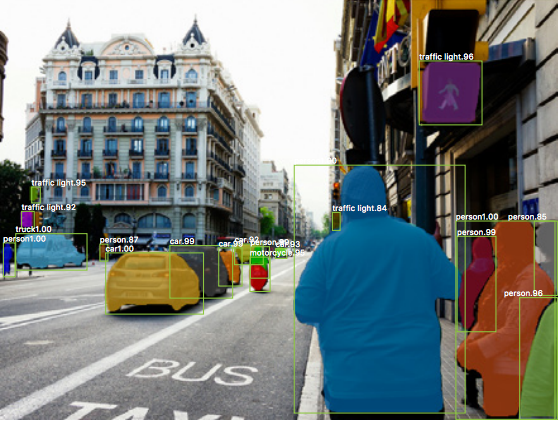

## 세그멘테이션의 발전

* R-CNN: https://arxiv.org/abs/1311.2524
  - 객체 탐지에 사용된 초기 모델
  - 주요 객체들을 바운딩 박스로 표현하여 정확히 식별하는게 목표
  - Selective Search를 통해 다양한 크기의 박스를 만들고, region proposal 영역 생성
  - region proposal 영역을 warp하여 표준화된 크기로 변환
  - AlexNet을 개량한 CNN 모델을 이용하고, 마지막 층에 SVM을 통해 객체 분류


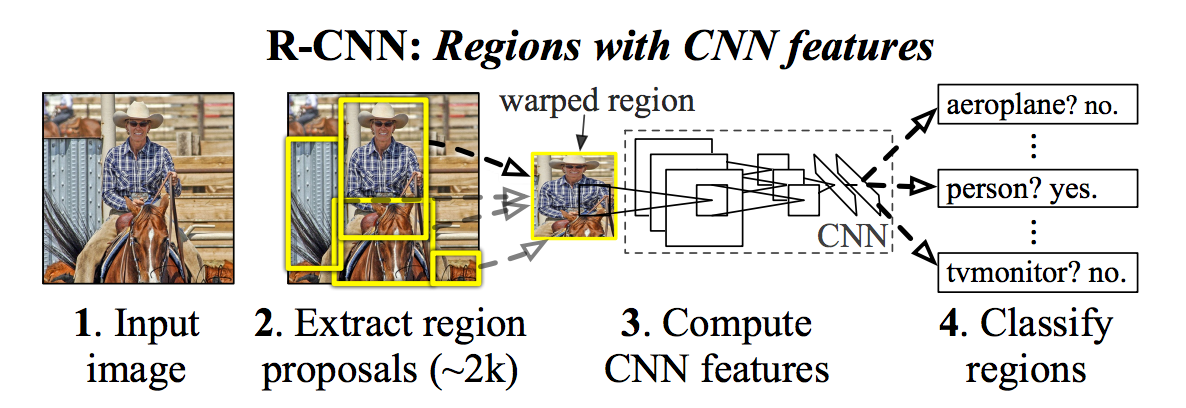

* Fast R-CNN: https://arxiv.org/abs/1504.08083
  - R-CNN의 단점인 느린 속도를 빠른 속도로 개선
  - ROI(Region of Interest) 풀링을 통해 한 이미지의 subregion에 대한 forward pass 값을 공유
  - R-CNN은 CNN 모델로 image feature를 추출, SVM 모델로 분류, Regressor 모델로 bounding box를 맞추는 작업으로 분류되어 있지만, Fast R-CNN은 하나의 모델로 동작
  - Top layer에 softmax layer를 둬서 CNN 결과를 class로 출력
  - Box regression layer를 softmax layer에 평행하게 두어 bounding box 좌표를 출력

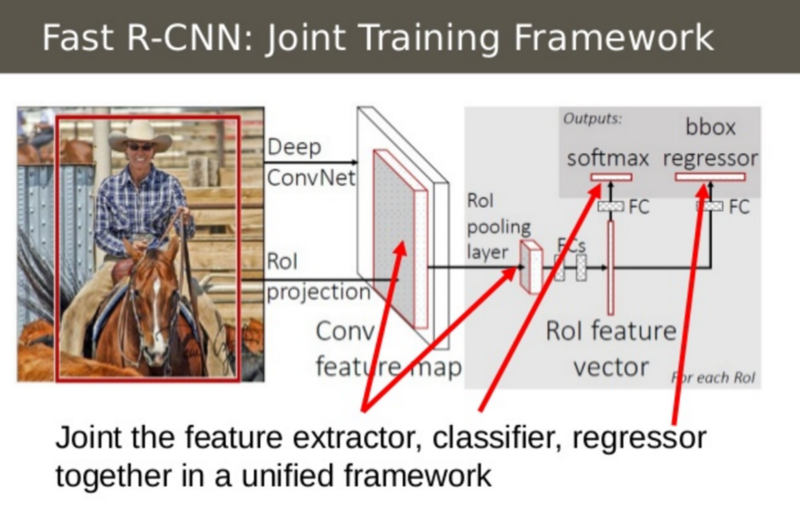

* Faster R-CNN: https://arxiv.org/abs/1506.01497
  - Fast R-CNN은 가능성 있는 다양한 bounding box들, 즉 ROI를 생성하는 과정인 selective search가 느려 region proposer에서 병목이 발생
  - 이미지 분류(classification)의 첫 단계인 CNN의 forward pass를 통해 얻어진 feature들을 기반으로 영역을 제안
  - CNN 결과를 selective search 알고리즘 대신 region proposal에 이용

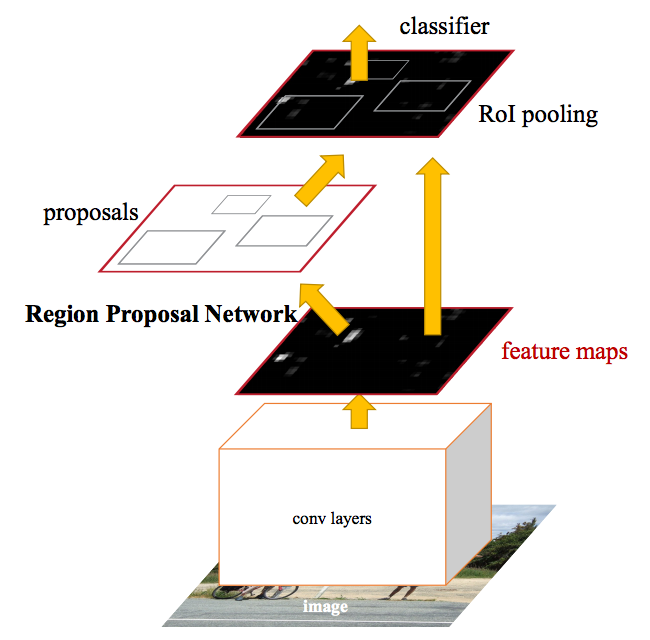

  - k개의 일반적인 비율을 지닌 anchor box를 이용하여 하나의 bounding box 및 score를 이미지의 위치별로 출력

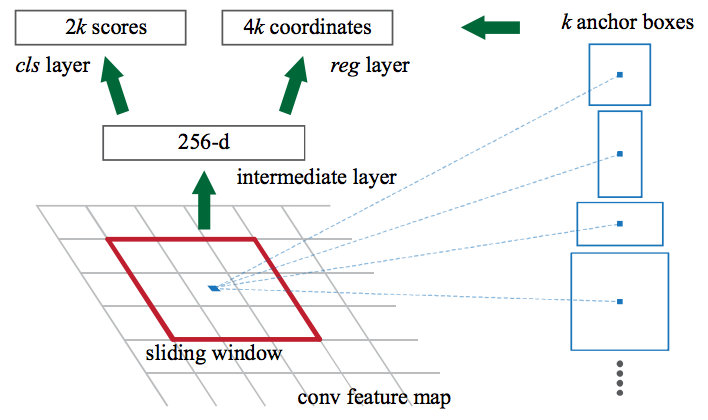

* Mask R-CNN: https://arxiv.org/abs/1703.06870
  - Pixel 레벨의 세그멘테이션
  - RolPool에서 선택된 feature map이 원래 이미지 영역으로 약간 잘못된 정렬이 발생한 부분을 RolAlign을 통해 조정하여 정확하게 정렬
  - Mask R-CNN은 Mask가 생성되면, Faster R-CNN으로 생성된 classification과 bounding box들을 합쳐 정확한 세그멘테이션 가능


# U-Net 기반 세그멘테이션

- 사용된 모델은 수정된 U-Net(https://arxiv.org/abs/1505.04597)
- U-Net이라 불리는 인코더(다운샘플링)와 디코더(업샘플링)를 포함한 구조는 정교한 픽셀 단위의 segmentation이 요구되는 biomedical image segmentation task의 핵심 요소
- Encoder-decoder 구조 또한 semantic segmentation을 위한 CNN 구조로 자주 활용
- Encoder 부분에서는 점진적으로 spatial dimension을 줄여가면서 고차원의 semantic 정보를 convolution filter가 추출해낼 수 있게 함
- Decoder 부분에서는 encoder에서 spatial dimension 축소로 인해 손실된 spatial 정보를 점진적으로 복원하여 보다 정교한 boundary segmentation을 완성
- U-Net은 기본적인 encoder-decoder 구조와 달리 Spatial 정보를 복원하는 과정에서 이전 encoder feature map 중 동일한 크기를 지닌 feature map을 가져 와 prior로 활용함으로써 더 정확한 boundary segmentation이 가능하게 함

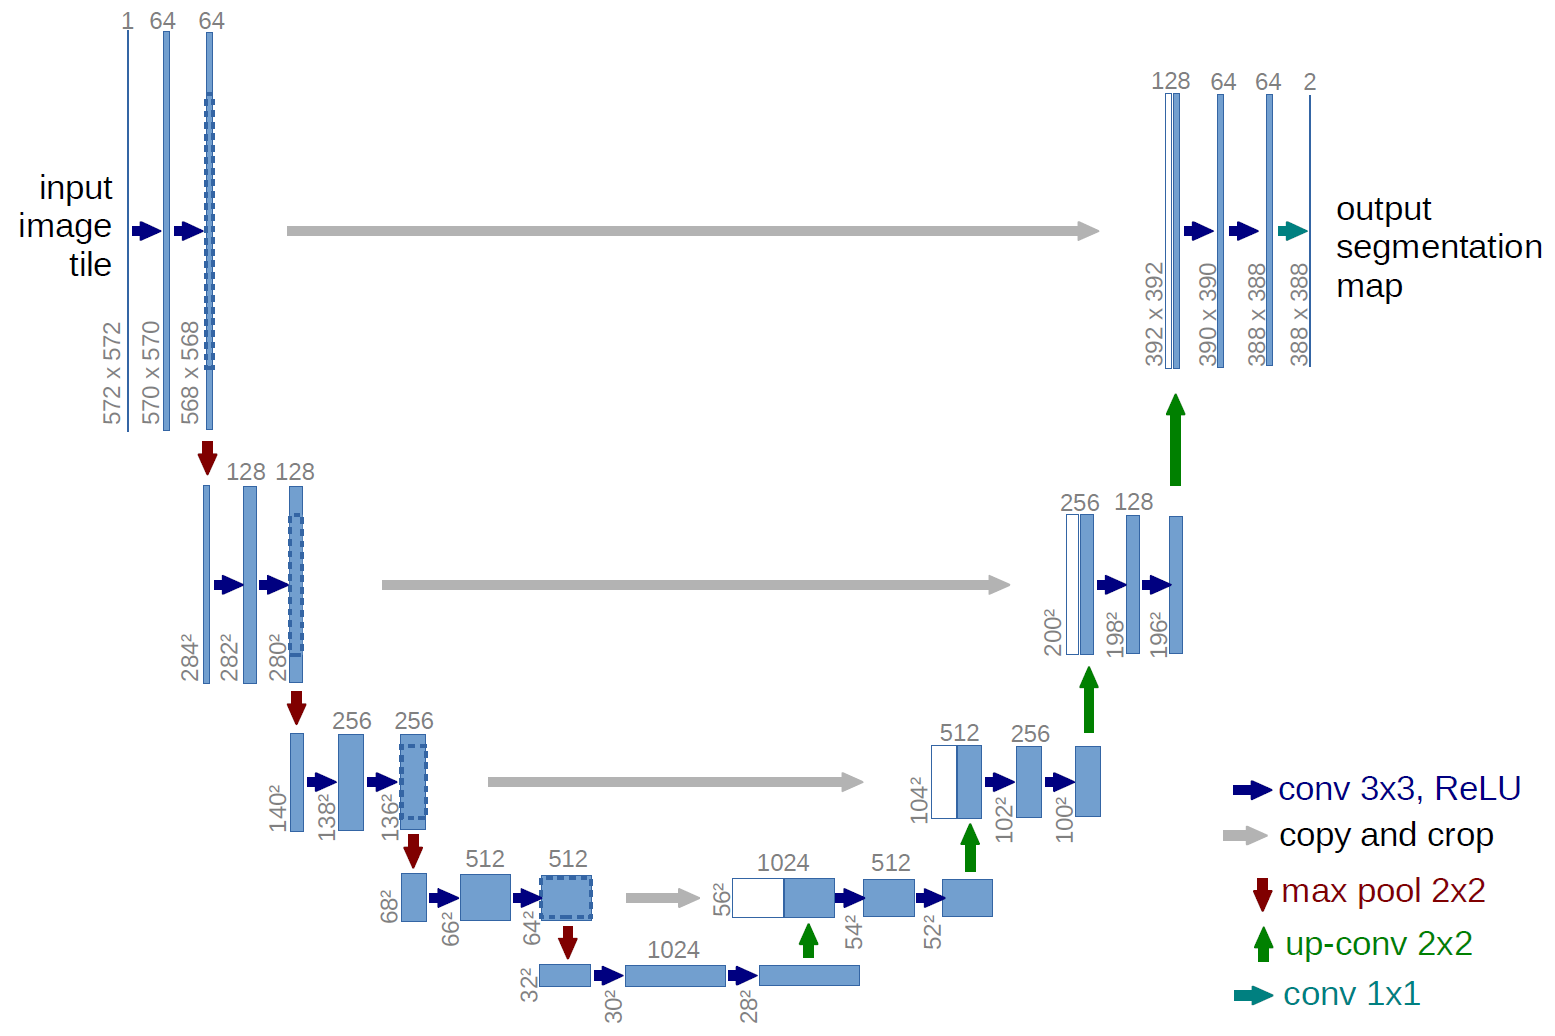

## Oxford-IIIT Pets 데이터셋

- Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성
- 마스크는 기본적으로 각 픽셀의 레이블
- 각 픽셀은 다음 세 가지 범주 중 하나
  *   class 1 : 애완동물이 속한 픽셀
  *   class 2 : 애완동물과 인접한 픽셀
  *   class 3 : 위에 속하지 않는 경우/주변 픽셀

- Images: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
- Annotations: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [ ]:
# 파일 가져오기
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
#압축풀기
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.0M      0  0:00:26  0:00:26 --:--:-- 29.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9741k      0  0:00:01  0:00:01 --:--:-- 9736k


In [ ]:
#압축 잘 풀렸는지 확인
!ls

annotations  annotations.tar.gz  images  images.tar.gz	sample_data


In [ ]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160,160)
#애완동물 속함, 인접픽셀, 속하지않음
num_classes = 3
batch_size = 32

#input_dir에 있는 파일 이름들을 하나씩 가져오기
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
                  if fname.endswith('.jpg')]) #jpg파일만 가져오기

#targer_dir에 있는 파일 이름들을 하나씩 가져오기
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir)
                  if fname.endswith('.png') and not fname.startswith('.')]) #png파일만 가져오기

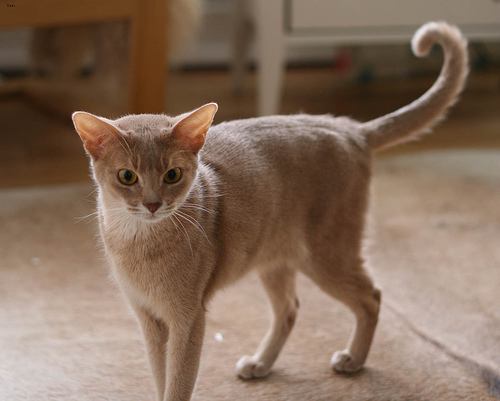

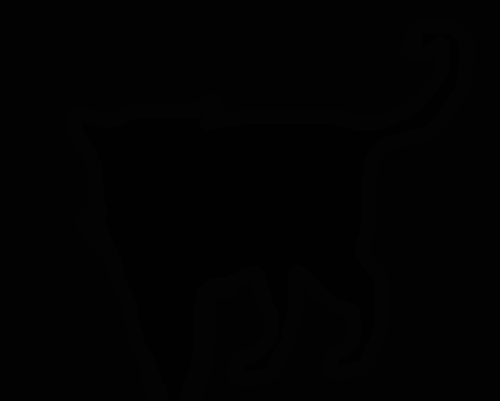

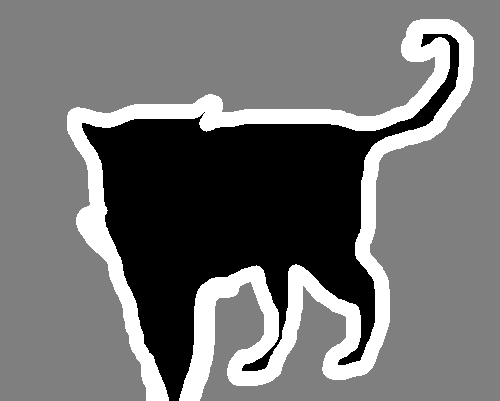

In [ ]:
#이미지로 paths값 확인하기
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img #이미지 불러오는 라이브러리
import PIL
from PIL import ImageOps

#input, target값 이미지로 불러오기
display(Image(filename=input_img_paths[20]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[20]))
display(img)

## 데이터 전처리

## 모델 구성

## 모델 학습

## 추론

# DeepLab 기반 세그멘테이션

* DeepLab V1: [Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs](https://arxiv.org/abs/1412.7062), ICLR 2015.
  - Atrous convolution은 기존 convolution과 다르게 필터 내부에 빈 공간을 둔 채로 작동
  - 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서 field of view (한 픽셀이 볼 수 있는 영역)를 크게 가져갈 수 있음
  - Semantic segmentation에서 일반적으로 높은 성능을 내기 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는지를 결정하는 receptive field 크기가 중요
  - Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에 DeepLab 계열에서는 이를 적극적으로 활용

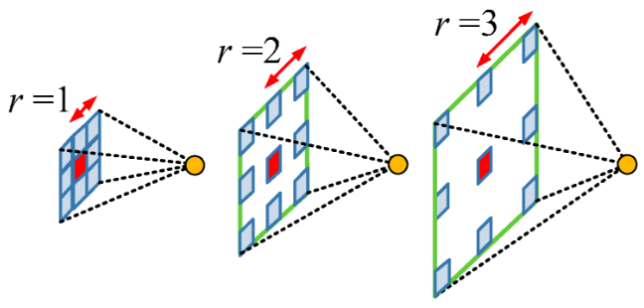

* DeepLab V2: [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915), TPAMI 2017.
  - Semantic segmentaion의 성능을 높이기 위한 방법 중 하나로, spatial pyramid pooling 기법을 자주 사용
  - Feature map으로부터 여러 개의 rate가 다른 atrous convolution을 병렬로 적용한 뒤, 이를 다시 합쳐주는 atrous spatial pyramid pooling (ASPP) 기법을 활용
  - multi-scale context를 모델 구조로 구현하여 보다 정확한 semantic segmentation을 수행할 수 있도록 함

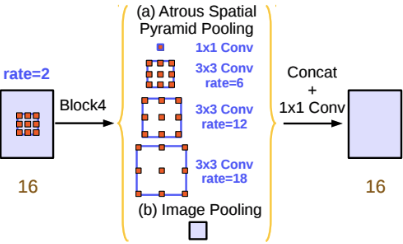

* DeepLab V3: [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587), arXiv 2017.

  - Encoder: ResNet with Atrous convolution
  - Atrous Spatial Pyramid Pooling (ASPP)
  - Decoder: Bilinear Upsampling


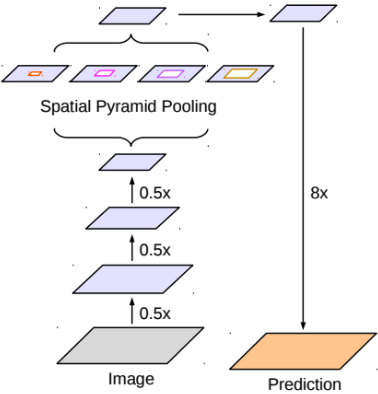

* DeepLab V3+: [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf), arXiv 2018.

  - Encoder: ResNet with Atrous Convolution → Xception (Inception with Separable Convolution)
  - ASPP → ASSPP (Atrous Separable Spatial Pyramid Pooling)
  - Decoder: Bilinear Upsampling → Simplified U-Net style decoder

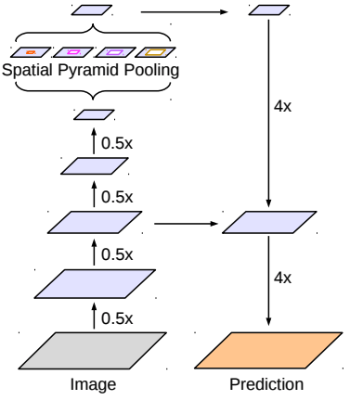

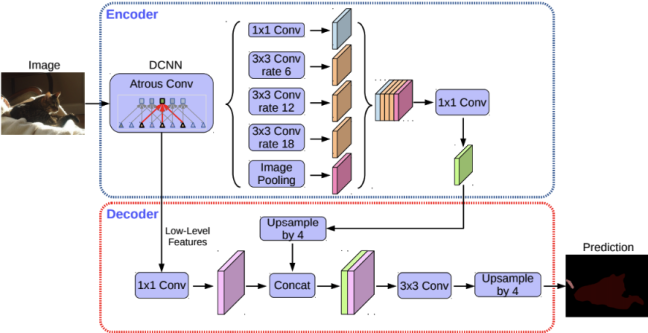

## 데이터셋 다운로드

* Crowd Instance-level Human Parsing (CIHP)(https://arxiv.org/abs/1811.12596)
* 38,280개의 다양한 인간 이미지
* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

## 모델 구성

* 인코더-디코더 구조를 확장
* 인코더 모듈: 확장된 컨볼루션을 여러 척도로 적용하여 다중 스케일 상황 정보 처리
* 디코더 모듈: 객체 경계를 따라 분할 결과 조정


* 확장된 컨볼루션(Dilated convolution)
  - 컨볼루션 확장을 통해 네트워크 깊숙히 들어가며 스트라이드를 일정하게 유지 가능
  - 매개변수의 수나 계산량을 늘리지 않고도 더 큰 시야를 가질 수 있음
  - 더 큰 특징 맵 출력이 가능하여 세그멘테이션에 유용함

* 확장된 공간 피라미드 풀링(Dilated Spatial Pyramid Pooling)
  - 샘플링 속도가 커질수록 유효한 필터 가중치(유효한 특징 영역에 적용되는 가중치)의 수가 작아짐


![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)




* 사전 훈련된 ResNet50을 백본 모델로 사용
* `conv4_block6_2_relu` 블록에서 저수준의 특징 사용

* 인코더 특징은 인자 4에 의해 쌍선형 업샘플링
* 동일한 공간 해상도를 가진 네트워크 백본에서 저수준 특징과 연결

## 모델 학습

## 추론

* 데이터셋과 함께 제공된 `./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat` 파일을 통해 각 라벨에 대한 해당 색상을 찾을 수 있음


# Detectron Mask R-CNN

* 페이스북 인공지능 연구소(FAIR)에서 공개한 플랫폼
* 빠르고 유연한 사물 탐지 가능

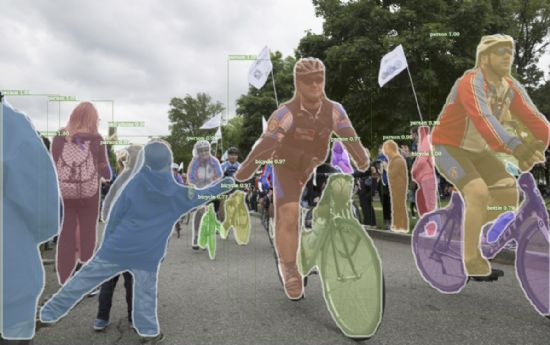

## Detectron 모델 설치

* Detectron Github: https://github.com/facebookresearch/Detectron.git

## 추론

* traffic_camera.jpg: https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/traffic_camera.jpg

* Config 파일: e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml
* 사전 모델: https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl

# Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

* 페이스북 인공지능 연구소(FAIR)에서 개발한 객체 세그멘테이션 프레임워크
* 페이스북에서 개발한 DensePose, Mask R-CNN 등을 Detectron2에서 제공
* 손쉽게 다양한 사물들을 탐지하고 세그먼테이션하여, 객체의 유형, 크기, 위치 등을 자동으로 얻을 수 있음



## Detectron2 설치

* Tutorial: https://detectron2.readthedocs.io/tutorials/install.html
* Detectron2: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

## 사전 모델

* input.jpg: http://images.cocodataset.org/val2017/000000439715.jpg

* Config 파일: COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml

## 커스텀 데이터셋 학습

### 데이터셋 준비

* Balloon 데이터셋: https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip

### 학습

* Config 파일: COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml


### 추론 및 평가



### 다른 타입 적용

* Config 파일: COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml

* Config 파일: COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml

### 비디오 파일 적용

* https://www.youtube.com/watch?v=ll8TgCZ0plk

* detectron2 github: https://github.com/facebookresearch/detectron2
* detectron2 config file: detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml
* model weights: detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl